# Filtering Data and Image Combination

Rebekah Esmaili (bekah@umd.edu) Research Scientist, STC/JPSS
 
---


## Lesson Objectives
* You will learn to:
    * Create new imagery by combining single channels
    * Basic 
   
---

## What do I need?
* If you are really new to Python, I recommend using the binder links to run these notebooks remotely.
* If you have some experience, you can either install Anaconda locally on your laptop or on a remote server. There are some instructions in the main directory.
* I _do not recommend_ using system or shared Python installations unless you are advanced!

---

Datasets:
* Several GOES-16 level 1 radiance data files:
    * Channel 2: OR_ABI-L1b-RadM1-M6C02_G16_s20192091147504_e20192091147562_c20192091147599.nc
    * Channel 3: OR_ABI-L1b-RadM1-M6C03_G16_s20192091147504_e20192091147562_c20192091148025.nc
    * Channel 13: OR_ABI-L1b-RadM1-M3C13_G16_s20182822019282_e20182822019350_c20182822019384.nc
* 3B-HHR.MS.MRG.3IMERG.20160811-S233000-E235959.1410.V06B.HDF5: IMERG is an 30-minute precipitation dataset
* sst.mon.ltm.1981-2010.nc: NOAA Extended Reconstructed Sea Surface Temperature (SST) V5 dataset

Start by importing 

In [1]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np, numpy.ma as ma
import pandas as pd
from cartopy import crs as ccrs
import scipy.interpolate

Some new libraries include

In [2]:
import h5py
import scipy.interpolate

## Combining multiple datasets
NDVI

In [3]:
# Import ABI Channel 3
fname = 'data/meso/OR_ABI-L1b-RadM1-M6C03_G16_s20192091147504_e20192091147562_c20192091148025.nc'
goesnc = Dataset(fname, 'r')
veggie = goesnc.variables['Rad'][:]

# Import ABI Channel 2
fname = 'data/meso/OR_ABI-L1b-RadM1-M6C02_G16_s20192091147504_e20192091147562_c20192091147599.nc'
goesnc = Dataset(fname, 'r')
red = goesnc.variables['Rad'][:]


In [4]:
red = red[::2, ::2]

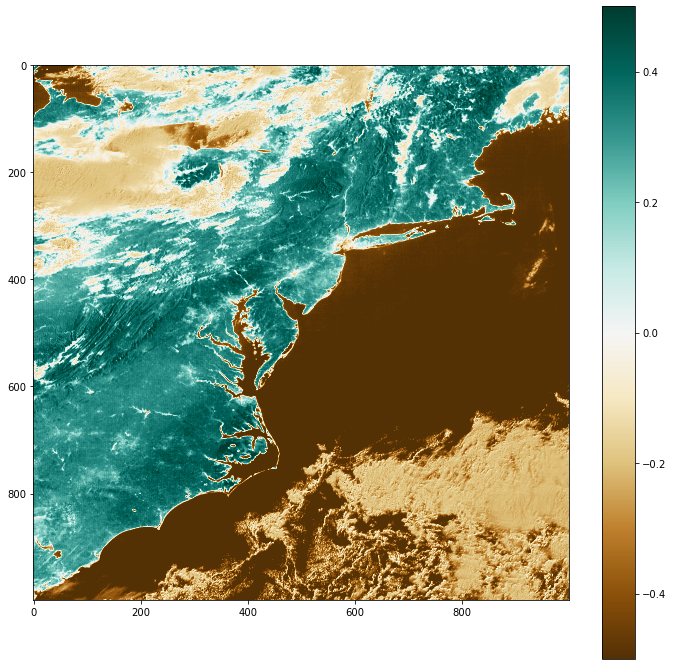

In [5]:
img = (veggie-red)/(veggie+red)

plt.figure(figsize=[12,12])
plt.imshow(img, vmin=-0.5, vmax=0.5, cmap=plt.get_cmap("BrBG"))
plt.colorbar()
plt.show()

---
**Exercise 1**: Combining images from two different channels
1. Open the two files using the netCDF4 library:
    * Channel 13: OR_ABI-L1b-RadM1-M3C13_G16_s20182822019282_e20182822019350_c20182822019384.nc
    * Channel 2: OR_ABI-L1b-RadM1-M3C02_G16_s20182822019282_e20182822019339_c20182822019374.nc
2. From each file, extract the 'Rad' variable (radiance) and save it to a new variable.
3. Check the dimensions, are they the same? If not, use the Numpy array slide syntax (::) to make the dimensions match.
4. Take the difference between channel 2 and  channel 13 (Ch02 - C13) 
5. Make a plot using plt.imshow().
---

**Solution:**

## Changing the grid

In [3]:
fname = 'data/3B-HHR.MS.MRG.3IMERG.20160811-S233000-E235959.1410.V06B.HDF5'
imergv6 = h5py.File(fname, 'r')

precip = imergv6['Grid/precipitationCal'][0,:,:]
lat = imergv6['Grid/lat'][:]
lon = imergv6['Grid/lon'][:]

In [4]:
Xold, Yold = np.meshgrid(lon, lat, indexing='ij')

In [22]:
grid_size=0.5

# coverage = [-180.0 , -90.0 , 180.0 , 90.0]
coverage = [-94.3, 28.9, -88.8, 33.1]

num_points_x = int((coverage[2] - coverage[0])/grid_size)
num_points_y = int((coverage[3] - coverage[1])/grid_size)

nx = complex(0, num_points_x)
ny = complex(0, num_points_y)

Xnew, Ynew = np.mgrid[coverage[0]:coverage[2]:nx, coverage[1]:coverage[3]:ny]

In [16]:
values = precip.flatten()

dims = (values.shape[0], 2)
points =  np.zeros(dims)

points[:, 0] = Xold.flatten()
points[:, 1] = Yold.flatten()

In [17]:
gridOut = scipy.interpolate.griddata(points, values, (Xnew, Ynew), method='nearest')

In [25]:
scipy.interpolate.griddata(points, values, (-94.3, 28.9), method='nearest')

0.00058759557

ValueError: cannot reshape array of size 0 into shape (0,newaxis)

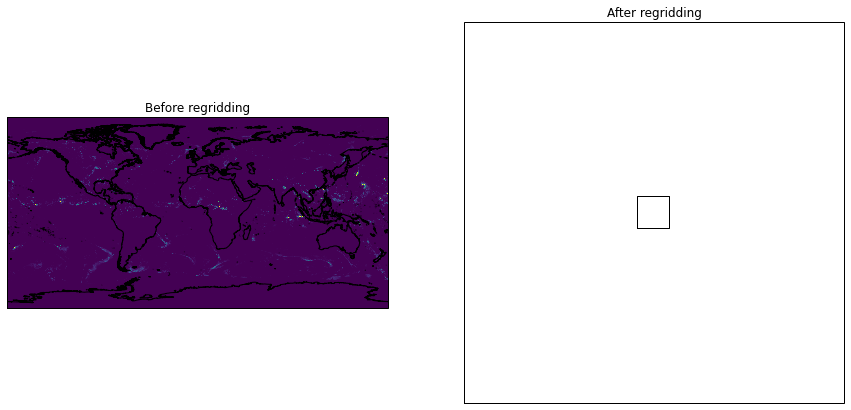

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=[15, 15],
   subplot_kw={'projection': ccrs.PlateCarree()})

for ax in axes:
#     ax.set_extent([-94.3, -88.8, 28.9, 33.1])
    ax.coastlines('10m', color='black')

axes[0].set_title("Before regridding")
axes[0].pcolormesh(Xold, Yold, precip, vmin=0, vmax=20)

axes[1].set_title("After regridding")
axes[1].pcolormesh(Xnew, Ynew, gridOut, vmin=0, vmax=20)

plt.show()

---
**Exercise 2**: Regridding a regularly spaced dataset

We will practice converting a 2 x 2 degree, regularly spaced grid to a 5-degree regularly spaced grid. This example has a lot of steps but closely follows the IMERG regridding example. We will use NOAA Extended Reconstructed Sea Surface Temperature (SST) V5 dataset, which has 2 degree spacing. This dataset is similar the the IMERG dataset, with the following differences:
* The SST dataset is netCDF, while IMERG is an HDF. There are no groups in the SST dataset.
* The longitude coordinates are expressed from 0 to 360 degrees; IMERG is from -180 to 180 degrees.
* The SST dataset has more than one time coordinate, we will use the first one (index 0), which corresponds to January. Feel free to look at any other ones!

Here are the steps:
1. Import sst.mon.ltm.1981-2010.nc, which has monthly long-term mean SST values.
2. Extract the following variables:
    * 'sst' is a 3-dimensional variable, time, lat, and lon. We will only import the first month (index 0), so use \[0,:,:\]
    * 'lat', 'lon' are 1-dimensional variables. Latitude goes from negative to positive, and longitude spans 0 to 360.
3. Define the new lat, lon grid that has 5 degrees of spacing
    * Create a new variable called gridsize
    * Calculate the number of longitude points and latitude 
4. Define a 1-dimensional list of the original 2 degree lat, lon grid
    * Create a 2-dimensional lat, lon using the np.meshgrid ( e.g. np.meshgrid(lon, lat, indexing='xy'))
5. Interpolate the original SST to the new 5-degree grid.
    * Flatten (using .flatten() ) the ssts so that it is 1-dimensional
6. Create a plot showing the old and the new data.
    * The data are from 0 to 360, we need to set the central longitude to -180 on the map!
    * You can change thevartiable names in the pcolormesh lines to reflect any differences in your variable names.
    
```python
fig = plt.figure(figsize=[15,15])

to_proj = ccrs.PlateCarree(central_longitude=-180)
from_proj = ccrs.PlateCarree()

ax = plt.subplot(projection=to_proj)
ax.coastlines('10m', color='black')

# For the original 2-degree grid
ax.pcolormesh(Xold, Yold, sst, vmin=0, vmax=30, transform=from_proj)

# For the new 5-degree grid
#ax.pcolormesh(Xnew, Ynew, gridOut, vmin=0, vmax=30, transform=from_proj)


plt.show()
```

---

**Solution:**

## Exporting data and Figures

### Saving as csv:

In [ ]:
name = ['GOES-16', 'IceSat-2', 'Himawari']
agency = ['NOAA', 'NASA', 'JAXA']
orbit = ['GEO', 'LEO', 'GEO']

df = pd.DataFrame({'name': name,
                   'agency': agency,
                   'orbit': orbit})

df.to_csv('satellites.csv', index=False)

### Saving as a binary file

In [ ]:
np.savez('satnames', name=name, agency=agency, orbit=orbit)

In [ ]:
npzfile = np.load('satnames.npz')
npzfile.files

### Saving figures

In [ ]:
plt.figure(figsize=[5,5]) 
plt.hist(fires['frp(MW)'],  bins=bins10MW)

plt.savefig('histogram.png',  bbox_inches='tight') 
plt.close()

## Scripting with Python

### Creating scripts from Jupyter Notebooks
One of the simplest ways to create a script is to convert an existing Jupyter notebook. As an example, we will created a notebook named script_example that only contains one line of code: print(“Hello Earth”). You can convert any Jupyter Notebook to a script by going to File → Download as → Python (.py):
 

This will download a new file (script_example.py) to your computer. If you open the file using your text editor, you will see:

```

#!/usr/bin/env python
# coding: utf-8

# In[1]:

print("Hello Earth")
```

You will notice that the script contains the line numbers (*ln\[1\]*), which in my opinion is unnecessary and should be removed from your script. Beginners, you can delete this extra formatting from your file.

### Running Python scripts from the command line

Now you are finished editing the code and you probably want to run it. There are two ways you can run Python scripts:

1. Using the command line interpreter
2. Using iPython

iPython is an interactive command line that allows you to run code in chunks. In fact, Jupyter Notebook is built using iPython, which explains the similarity in behavior.
 
* Windows: I suggest using the Anaconda Prompt which you can access from the start menu or using Anaconda Navigator. 
* MacOs/Linux: open the Terminal app. 

Once the command line is open, you start in a default location. For example, if you are using Windows and launch the Anaconda Prompt you will see:

```
(base) C:\Users\rebekah>
```

Now, navigate to where our script is. To do this, you will change directories using the cd command. For example, if your code is stored in C:\Documents\Python, you can type:

```

cd C:\Documents\Python
```

The command line will now be updated showing:

```
(base) C:\Documents\Python>
```

Now that you are in the right place, you can call the Python interpreter, which to convert your code into a format that your computer can understand and executes the command. If you installed Anaconda, this includes a Python 3 interpreter (*python3*). So, to run the script, type:

```
python3 hello_world.py
```

If successful, “Hello Earth” should print to your screen.

A second method is to use iPython, which allows you to open Python in interactive mode. Unlike the command line method, iPython will let you run code line-by-line. So, like Jupyter Notebook, you have the option to copy and paste you code from the text editor in chunks into the iPython window. You can also call the entire script inside iPython. This is done by starting iPython and using the command %run \[script name\].py. Below is a capture from my terminal:

```
Python 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
Type 'copyright', 'credits' or 'license' for more information
IPython 7.12.0 -- An enhanced Interactive Python. Type '?' for help.

In [1]: %run script_example.ipynb
Hello Earth
```

One advantage of using iPython is that after the script finishes running, variables that were generated in the script are still in memory. Then, you can print or operate on the variables to either debug or to develop your code further. 

You may have noted two differences in workflow for write code in scripts versus notebooks, (1) that code cannot be inline and (2) the program must run fully to the end.


### Handling output when scripting

In the previous example, you printed text to the screen but Python’s capable of saving figures and data. To save plots, replace *plt.show()* with the *plt.savefig()* command.

It is possible to directly display your graphics using the X11 protocol (by default in Linux) with XQuartz (Mac) or PuTTy (Windows). 

I typically discourage this because satellite imagery tends to be very large and thus slow to display remotely. From my experience, it is usually faster to write an image to a file and then view the plot after it is fully rendered.

## Summary:

You learned:

* How to combine single-channel imagery
* Change grid size from regularly-spaced data
* How to save data and graphics